# Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**План работы**
1. Загрузить и изучить данные.
2. Предобработать данные - убрать пропуски и дубликаты, привести к корректному типу.
3. Исследовать данные - графики, выбросы.
4. Объединить отдельные наборы данных в одну таблицу
5. Корреляционный анализ признаков - рассчитать коэффициенты корреляции, построить графики.
6. Создать пайплайн и выбрать лучшую модель для прогонза
7. Проанализировать важность признаков для лучшей модели
8. Сделать сегментацию покупателей
9. Итоговые выводы

**Описание данных**

Данные для работы находятся в нескольких таблицах.

**market_file.csv**
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

**market_money.csv**
Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период.

**market_time.csv**
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.

**money.csv**
Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

# Шаг 1. Загрузка данных

In [2]:
#установка phik
! pip install phik -q # ! маркер системной команды в Jupyter, -q убирает необязательные выводы в командах Linux

#установка shap
!pip install shap -q

In [3]:
#импортирую нужные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap

from phik.report import plot_correlation_matrix
from phik import report
from scipy import stats as st
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC


In [4]:
#загружаю файлы
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv',sep=';',decimal=',')

In [5]:
display(market_file.head())
market_file.info()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [6]:
display(market_money.head())
market_money.info()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [7]:
display(market_time.head())
market_time.info()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [8]:
display(money.head())
money.info()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Вывод**

На первый взгляд данные хорошие - пропусков нет, типы данных соответствуют заявленным. Категориальные призанки с типом object, количественные - с типом float или int.

# Шаг 2. Предобработка данных

**Датасет market_file**

In [9]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [10]:
#проверю нечисловые столбцы типа на уникальные значения
for i in market_file.select_dtypes(exclude='number').columns:
    display(market_file[i].value_counts())

Прежний уровень    802
Снизилась          498
Name: Покупательская активность, dtype: int64

стандарт     914
премиум      376
стандартт     10
Name: Тип сервиса, dtype: int64

да     962
нет    338
Name: Разрешить сообщать, dtype: int64

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная_категория, dtype: int64

In [11]:
#в "Типе сервиса" заменю ошибочное значение "стандартт"
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace('стандартт','стандарт')
market_file['Тип сервиса'].value_counts()

стандарт    924
премиум     376
Name: Тип сервиса, dtype: int64

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


array([[<AxesSubplot:title={'center':'Маркет_актив_6_мес'}>,
        <AxesSubplot:title={'center':'Маркет_актив_тек_мес'}>,
        <AxesSubplot:title={'center':'Длительность'}>],
       [<AxesSubplot:title={'center':'Акционные_покупки'}>,
        <AxesSubplot:title={'center':'Средний_просмотр_категорий_за_визит'}>,
        <AxesSubplot:title={'center':'Неоплаченные_продукты_штук_квартал'}>],
       [<AxesSubplot:title={'center':'Ошибка_сервиса'}>,
        <AxesSubplot:title={'center':'Страниц_за_визит'}>,
        <AxesSubplot:>]], dtype=object)

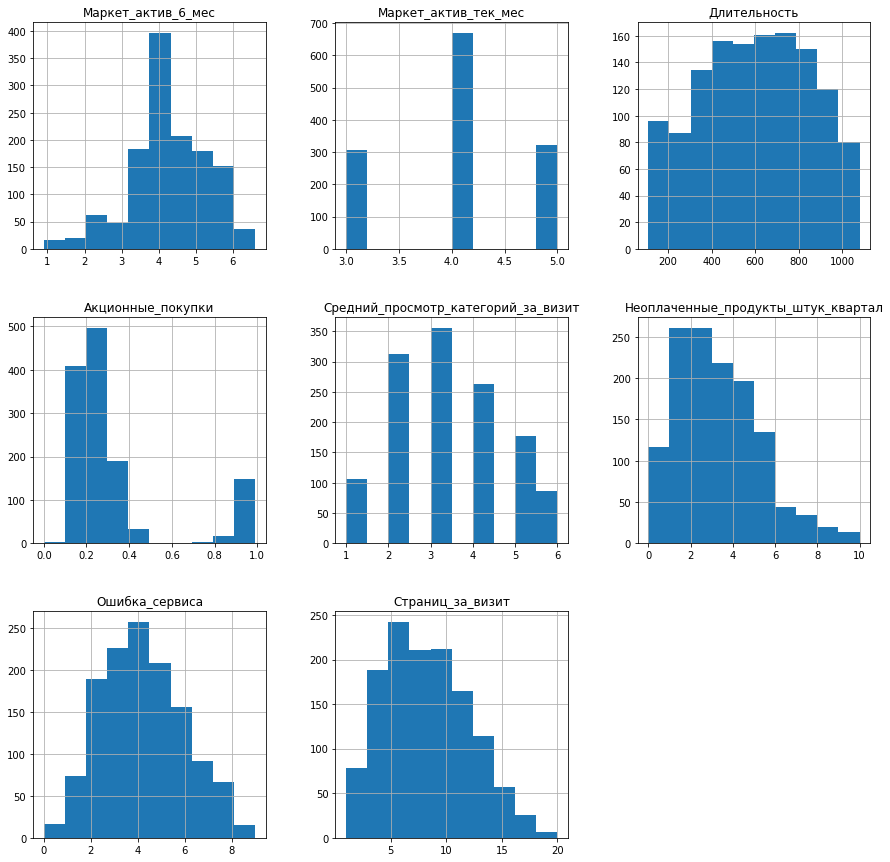

In [12]:
display(market_file.drop('id',axis=1).describe())
display(market_file.drop('id',axis=1).hist(figsize=(15,15)));
#числовые столбцы нареканий не вызывают

In [13]:
#проверю на общие дубликаты
market_file.duplicated().sum()

0

**Датасет market_money**

In [14]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [15]:
#проверю нечисловые столбцы типа на уникальные значения
market_money['Период'].value_counts()

текущий_месяц          1300
препредыдущий_месяц    1300
предыдущий_месяц       1300
Name: Период, dtype: int64

,Выручка
count,3900.000000
mean,5025.696051
std,1777.704104
min,0.000000
25%,4590.150000
50%,4957.500000
75%,5363.000000
max,106862.200000


array([[<AxesSubplot:title={'center':'Выручка'}>]], dtype=object)

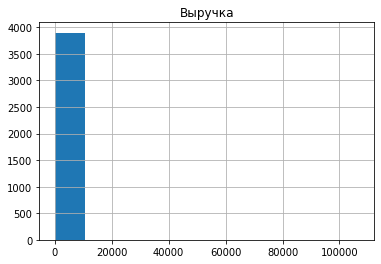

In [16]:
display(market_money.drop('id',axis=1).describe())
display(market_money.drop('id',axis=1).hist());

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


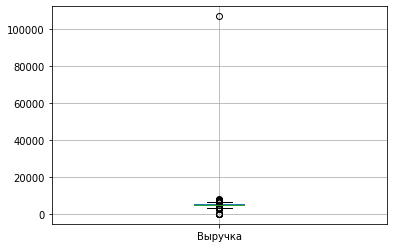

In [17]:
#посмотрю на крупное значение выручки
market_money.boxplot('Выручка')
market_money.query('Выручка > 8000')

In [18]:
#одно значение выбивается из всех, удалю его
market_money = market_money.drop(98)
market_money.drop('id',axis=1).describe()

,Выручка
count,3899.00000
mean,4999.57743
std,706.99988
min,0.00000
25%,4590.10000
50%,4957.00000
75%,5363.00000
max,7799.40000


In [19]:
#проверю на общие дубликаты
market_money.duplicated().sum()

0

**Датасет market_time**

In [20]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [21]:
#проверю нечисловые столбцы типа на уникальные значения
market_time['Период'].value_counts()

предыдцщий_месяц    1300
текущий_месяц       1300
Name: Период, dtype: int64

In [22]:
#заменю ошибочное значение "предыдцщий_месяц"
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц','предыдущий месяц')
market_time['Период'].value_counts()

текущий_месяц       1300
предыдущий месяц    1300
Name: Период, dtype: int64

,минут
count,2600.000000
mean,13.336154
std,4.080198
min,4.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,23.000000


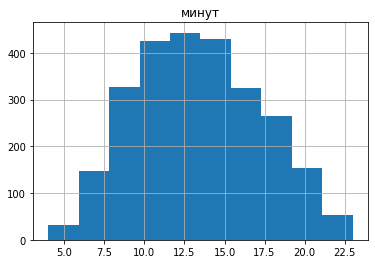

In [23]:
display(market_time.drop('id',axis=1).describe())
market_time.drop('id',axis=1).hist();

In [24]:
#проверю на общие дубликаты
market_time.duplicated().sum()

0

**Датасет money**

In [25]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,Прибыль
count,1300.000000
mean,3.996631
std,1.013722
min,0.860000
25%,3.300000
50%,4.045000
75%,4.670000
max,7.430000


array([[<AxesSubplot:title={'center':'Прибыль'}>]], dtype=object)

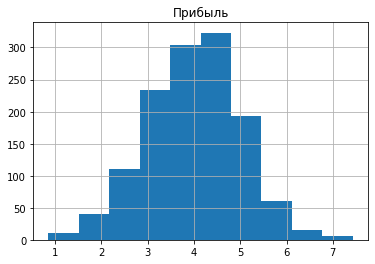

In [26]:
display(money.drop('id',axis=1).describe())
display(money.drop('id',axis=1).hist());

In [27]:
#проверю на общие дубликаты
money.duplicated().sum()

0

**Выводы**

Данные в целом неплохие. Исправления, которые сделал:
- исправил категорию "стандартт"
- удалил выброс в выручке со значением в 100 тысяч рублей (при среднем в 5 тысяч рублей)
- исправил значение "предыдцщий_месяц"

# Шаг 4. Объединение таблиц

In [28]:
#объединять буду по столбцу id
#для начала разделю данные о периодах на отдельные столбцы
market_money_pivot = market_money.pivot_table(index='id',columns='Период',values='Выручка',aggfunc='sum')
market_time_pivot = market_time.pivot_table(index='id',columns='Период',values='минут',aggfunc='sum')
market_money_pivot.columns = ['Выручка_пр_месяц','Выручка_пр_пр_месяц','Выручка_тек_месяц']
market_time_pivot.columns = ['Минут_пр_месяц','Минут_тек_месяц']
display(market_money_pivot)
display(market_time_pivot)

,Выручка_пр_месяц,Выручка_пр_пр_месяц,Выручка_тек_месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
...,...,...,...
216643,3664.0,4704.0,4741.7
216644,4729.0,5299.0,5353.0
216645,5160.0,5334.0,5139.2


,Минут_пр_месяц,Минут_тек_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11
...,...,...
216643,14,7
216644,12,11
216645,12,18


In [29]:
df = market_file.set_index('id').merge(market_money_pivot,on='id')
df= df.merge(market_time_pivot,on='id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1300 non-null   object 
 1   Тип сервиса                          1300 non-null   object 
 2   Разрешить сообщать                   1300 non-null   object 
 3   Маркет_актив_6_мес                   1300 non-null   float64
 4   Маркет_актив_тек_мес                 1300 non-null   int64  
 5   Длительность                         1300 non-null   int64  
 6   Акционные_покупки                    1300 non-null   float64
 7   Популярная_категория                 1300 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 10  Ошибка_сервиса                       1300 non-null   int64  
 11  Страниц_за_визит       

In [30]:
#отберу покупателей с активностью за предоставленные 3 месяца
df = df.query('Выручка_пр_месяц >0 & Выручка_пр_пр_месяц >0 & Выручка_тек_месяц >0')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1296 non-null   object 
 1   Тип сервиса                          1296 non-null   object 
 2   Разрешить сообщать                   1296 non-null   object 
 3   Маркет_актив_6_мес                   1296 non-null   float64
 4   Маркет_актив_тек_мес                 1296 non-null   int64  
 5   Длительность                         1296 non-null   int64  
 6   Акционные_покупки                    1296 non-null   float64
 7   Популярная_категория                 1296 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  Ошибка_сервиса                       1296 non-null   int64  
 11  Страниц_за_визит       

Разделил данные для периодов на разные столбцы и объединили датасеты в общий df.

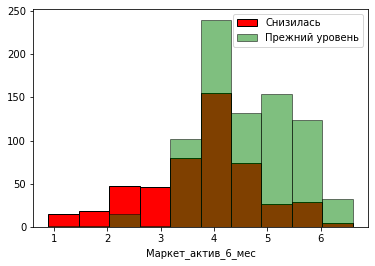

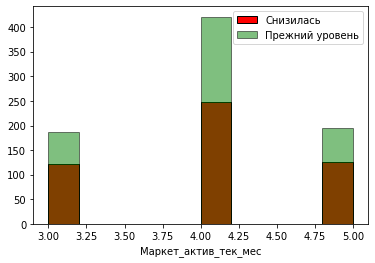

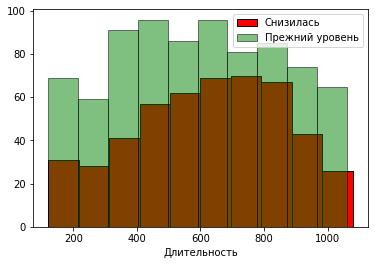

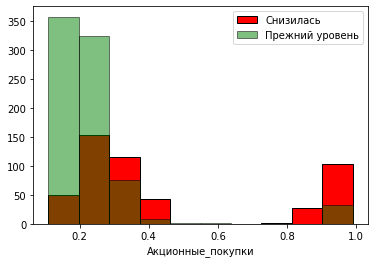

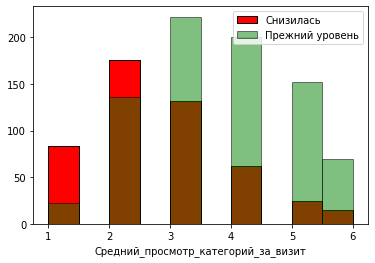

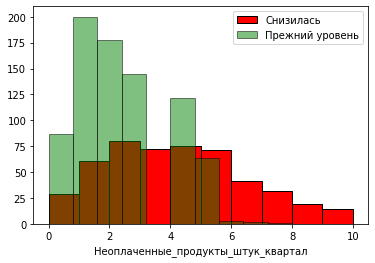

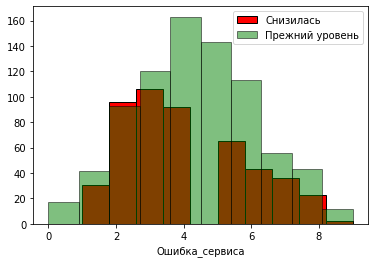

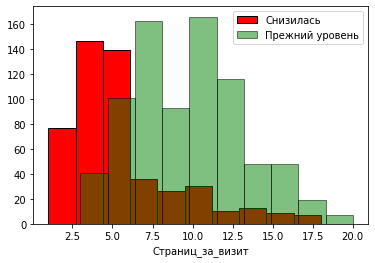

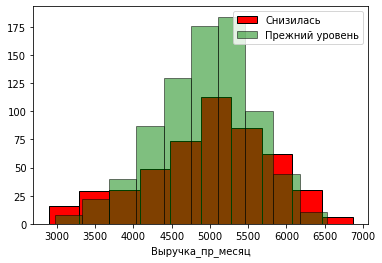

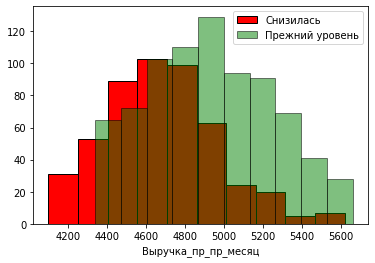

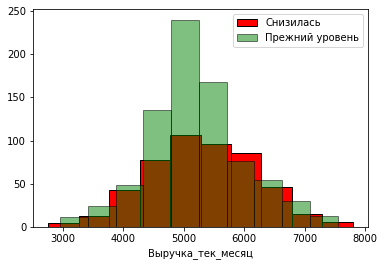

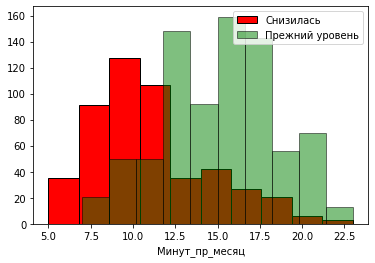

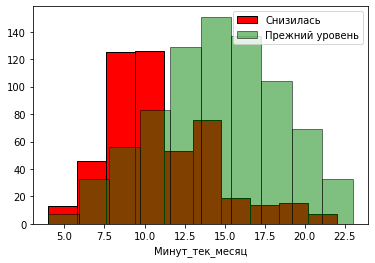

In [31]:
cat = ['Тип сервиса', 'Разрешить сообщать','Популярная_категория']
num = df.select_dtypes(include='number').columns
df = df.rename(columns={'Покупательская активность':'покупательская_активность'})

low = df.query('покупательская_активность == "Снизилась"')
same = df.query('покупательская_активность == "Прежний уровень"')

for i in num:
    plt.hist(low[i], edgecolor='black',color='red',bins=10,label='Снизилась')
    plt.hist(same[i], edgecolor='black',color='green',bins=10,label='Прежний уровень',alpha=0.5)
 
    plt.legend(loc='upper right')
 
    plt.xlabel(i)
 
    plt.show()

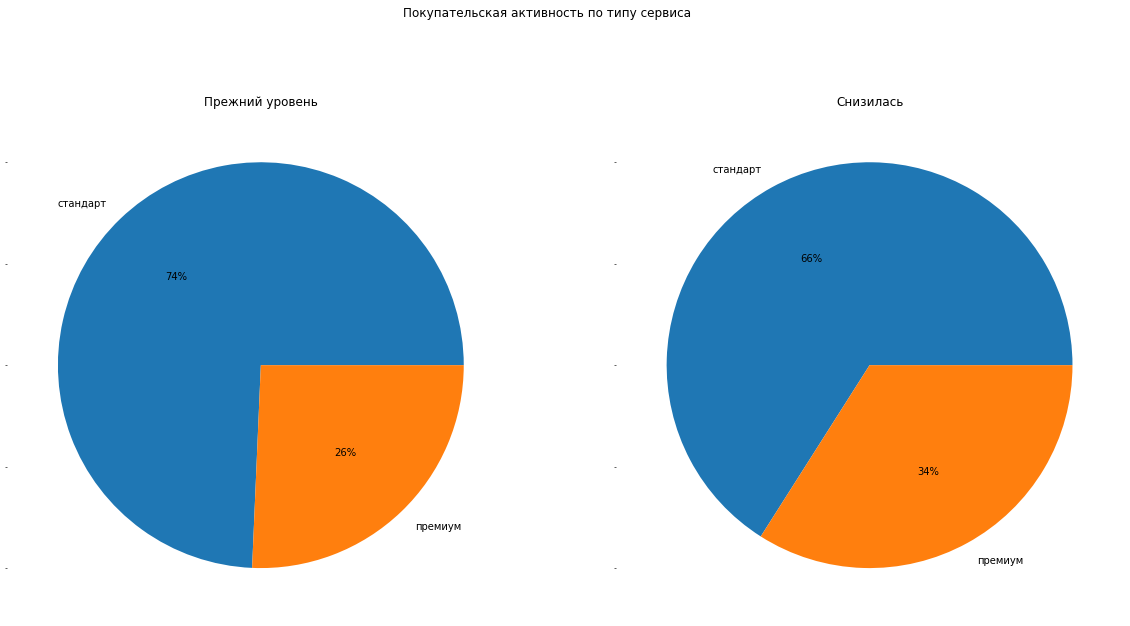

In [32]:
#круговые диаграммы
fig,(ax0,ax1) = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(20,10));
fig.suptitle('Покупательская активность по типу сервиса',y=1);
same['Тип сервиса'].value_counts().plot(kind='pie',y='Тип сервиса',ax=ax0,autopct='%1.0f%%',legend=None);
low['Тип сервиса'].value_counts().plot(kind='pie',y='Тип сервиса',ax=ax1,autopct='%1.0f%%',legend=None);
ax0.set(title='Прежний уровень',ylabel='');
ax1.set(title='Снизилась');

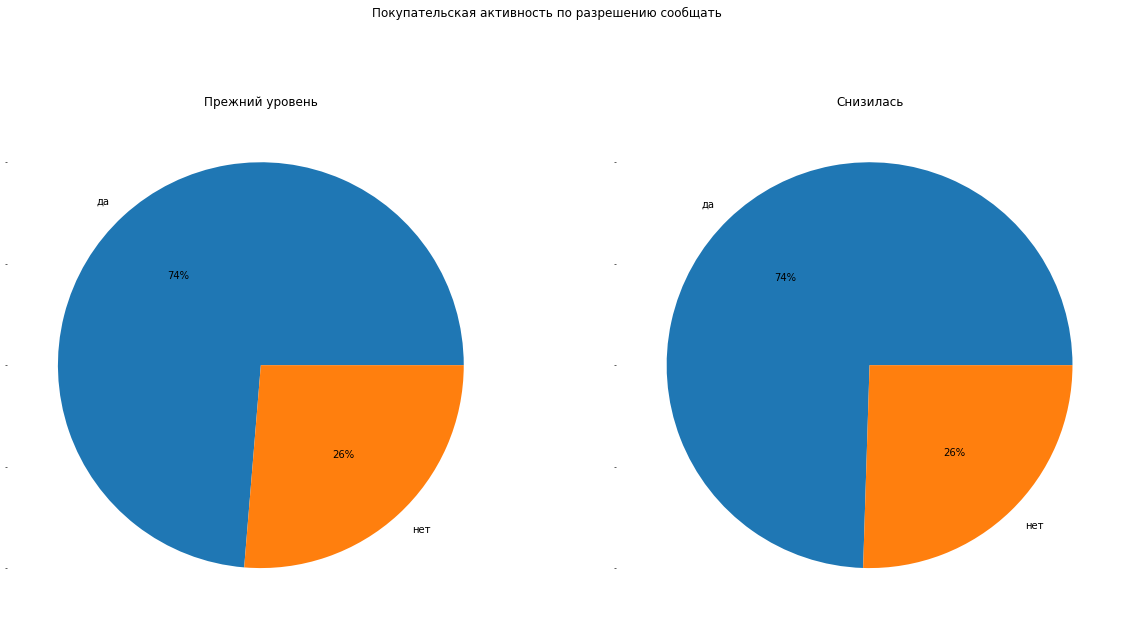

In [33]:
fig,(ax0,ax1) = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(20,10));
fig.suptitle('Покупательская активность по разрешению сообщать',y=1);
same['Разрешить сообщать'].value_counts().plot(kind='pie',y='Разрешить сообщать',ax=ax0,autopct='%1.0f%%',legend=None);
low['Разрешить сообщать'].value_counts().plot(kind='pie',y='Разрешить сообщать',ax=ax1,autopct='%1.0f%%',legend=None);
ax0.set(title='Прежний уровень',ylabel='');
ax1.set(title='Снизилась');

**Вывод**

Для каждого количественного признака наложил гистограммы в зависимости от типа покупательской активности. Складывается ощущение, что люди, у которых снизилась активность изначально приходили за акционными товарами:
- распределение в акционных покупках - люди из категории "снизилась" покупают меньше акционных товаров;
- в среднем смотрят меньше категорий за визит;
- у них чаще встречаются неоплаченные покупки;
- чаще смотрят лишь несколько страниц;
- и соответственно чаще проводят меньшее количество минут на сайте

При этом с точки зрения катгорий - снижение произошло среди премиальных подписок

# Шаг 5. Корреляционный анализ


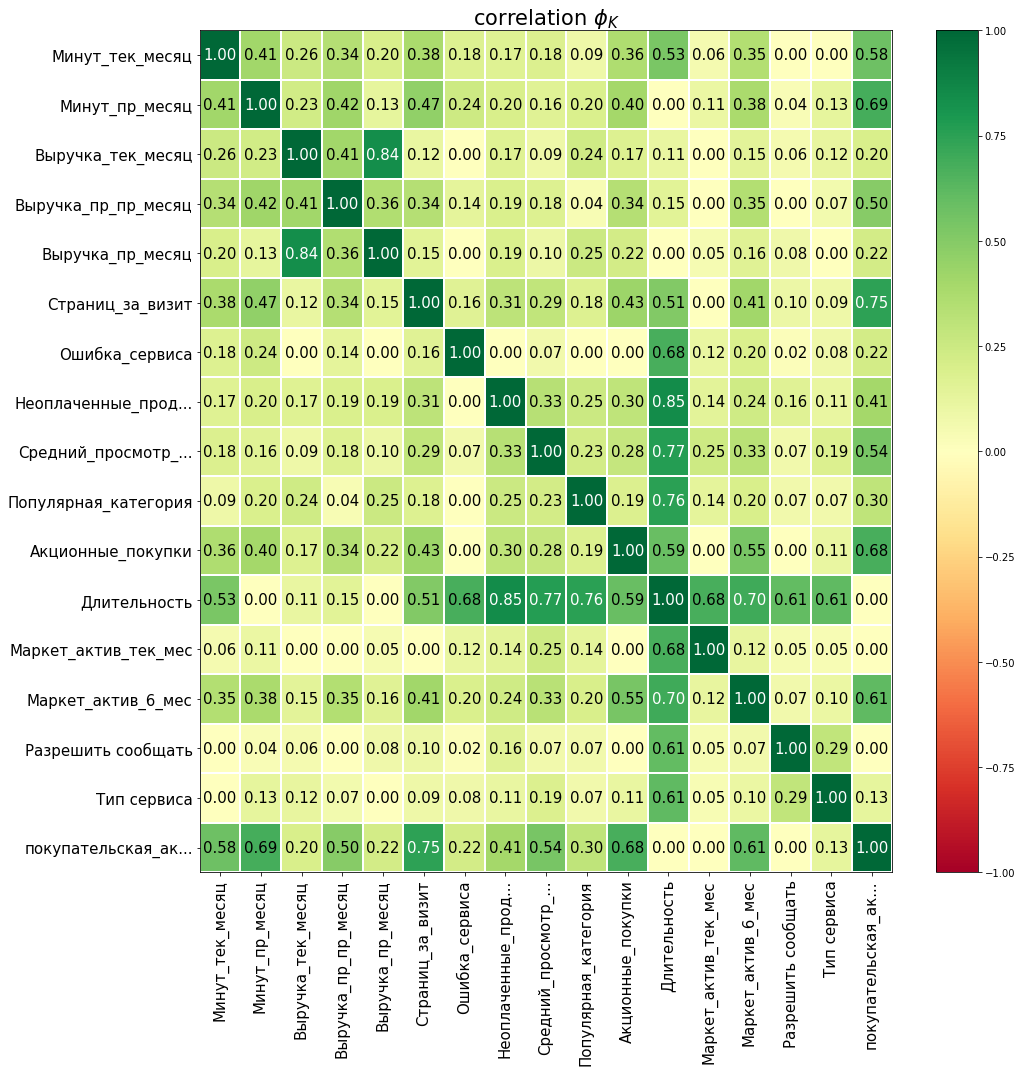

In [34]:
#для корреляционного анализа использую тепловую карту коэффициентов кореляции ф
interval_cols =['Выручка_пр_месяц','Выручка_пр_пр_месяц','Выручка_тек_месяц','Минут_пр_месяц',
               'Минут_тек_месяц']
# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = df.phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 15)
)

На целевой показатель "Покупательская активность" больше всего влияют показатели:
- выручки
- проведенных минут на сайте
- количество просмотренных страниц за один визит
- количество просмотренных категорий за один визит
- акционные покупки
- маркетинговая активность за 6 месяцев

В свою очередь такие параметры как длительность, маркетинговая активность в текущем месяце и разрешение на предложение товаров вообще никак не влияет на целевой показатель.

Так же, выбор этих показателей позволит устранить внутренние зависимости, как например маркетинговая активность за 6 месяцев и давность регистрации пользователя на сайте.
Самая явная мультиколлениарность у длительности - она коррелирует со многими показателями, такими как ошибки сервиса, неоплаченные покупки, популярные категории и тд.

In [35]:
df_new = df[['покупательская_активность','Минут_тек_месяц','Минут_пр_месяц','Выручка_тек_месяц',
             'Выручка_пр_пр_месяц','Выручка_пр_месяц', 'Страниц_за_визит','Средний_просмотр_категорий_за_визит',
             'Акционные_покупки','Маркет_актив_6_мес']]
df_new['target'] = np.where(df_new['покупательская_активность']=='Снизилась',1,0)
df_new = df_new.drop('покупательская_активность',axis=1)
df_new.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Минут_тек_месяц,Минут_пр_месяц,Выручка_тек_месяц,Выручка_пр_пр_месяц,Выручка_пр_месяц,Страниц_за_визит,Средний_просмотр_категорий_за_визит,Акционные_покупки,Маркет_актив_6_мес,target
id,,,,,,,,,,
215349,10,12,4971.6,4472.0,5216.0,5,4,0.75,4.4,1
215350,13,8,5058.4,4826.0,5457.5,5,5,0.14,4.9,1
215351,13,11,6610.4,4793.0,6158.0,4,5,0.99,3.2,1
215352,11,8,5872.5,4594.0,5807.5,2,3,0.94,5.1,1
215353,10,10,5388.5,5124.0,4738.5,4,4,0.26,3.3,1


# Шаг 6. Использование пайплайнов

In [36]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

# делаем разбивку на тренировочные и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(
    df_new.drop(['target'], axis=1),
    df_new['target'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    )

X_train.shape, X_test.shape

# создаём списки с названиями признаков
num_columns = ['Минут_тек_месяц','Минут_пр_месяц','Выручка_тек_месяц',
             'Выручка_пр_пр_месяц','Выручка_пр_месяц', 'Страниц_за_визит','Средний_просмотр_категорий_за_визит',
             'Акционные_покупки','Маркет_актив_6_мес']

ohe_columns = []

ord_columns = []

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {'models': [SVC(random_state=RANDOM_STATE)]}
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверяем работу модели на тестовой выборке
# рассчитываем прогноз на тестовых данных

#label_encoder = LabelEncoder()
#y_train_encoded = label_encoder.fit_transform(y_train)
#y_test_encoded = label_encoder.transform(y_test)

y_test_pred = randomized_search.predict_proba(X_test)[:,1]
#y_test_pred_encoded = label_encoder.transform(y_test_pred)
print('Площадь ROC-кривой: ',roc_auc_score(y_test, y_test_pred))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  []),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                        

**Вывод**

Судя по рандомизированному поиску параметров, лучшая модель - логистическая регрессия. 

Для оценки я выбрал ROC-кривую — это график, который отображает динамику качества классификации при разных порогах. Он показывает зависимость между TPR и FRP — промежуточными метриками, которые оценивают число верно классифицированных объектов класса 1 и неверно классифицированных объектов класса 0. Метрику можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другими. Это как раз наш случай - в данных целевые значения распределены 1 к 2.

При этом точность такой модели на тренировочной выборке составляет 0.9. И на тестовой выборке она не отличается - так же 0.9.

# Шаг 7. Анализ важности признаков

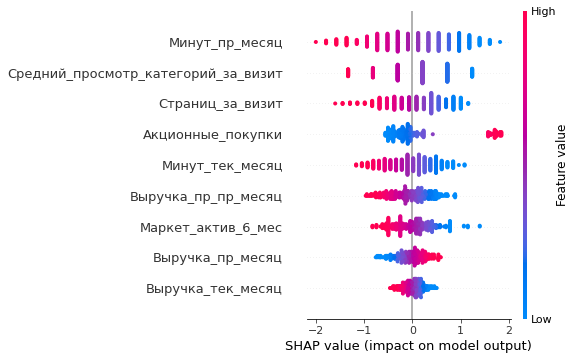

In [38]:
model = randomized_search.best_estimator_

# Получаем лучшую модель из randomized_search
best_model = randomized_search.best_estimator_

# Извлекаем модель из конвейера
model_from_pipe = best_model.named_steps['models']

# Создаем объяснитель SHAP для линейной модели
explainer = shap.LinearExplainer(model_from_pipe, X_train)

# Вычисляем SHAP значения на тестовых данных
shap_values = explainer.shap_values(X_test)

# Визуализируем результаты SHAP
shap.summary_plot(shap_values, X_test)


**Вывод**

Судя по визуализации SHAP, выбранные признаки оказывают существенное влияние на целевую переменную. Например, чем больше количество проведенных минут на сайте, тем выше вероятность, что модель присвоит значение целево переменно равное 0, то есть, что запишет в активные клиенты. 

Но отдельно я бы отметил показатель акционные покупки. В этой строке графика можно заметить красный всплеск справа. Получается, что снижение активности связано с (или после) акционных покупок. Это же мы заметили в шаге 4, когда проводили исследовательский анализ данных

# Шаг 8. Сегментация покупателей

Как я уже обратил внимание раньше, стоит уделить сегменту покупателей с высокой долей акционных покупок.

<AxesSubplot:>

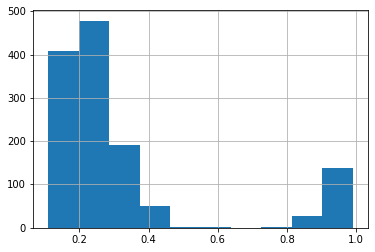

In [39]:
df['Акционные_покупки'].hist()

Распределение доли акционных покупок показывает два условных интервала - от (0.1, 0.5) и (0.6, 1).

Построю диаграмму рассеяния для каждого количественного признака в зависимости от доли акционных покупок, с учетом покупательской активности.

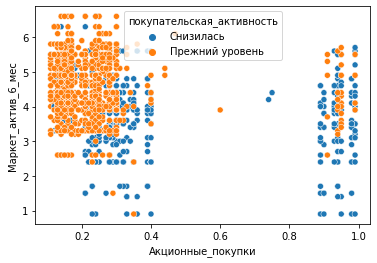

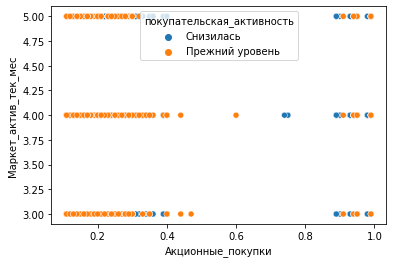

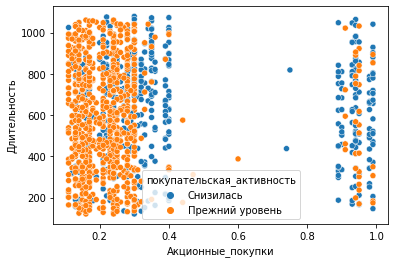

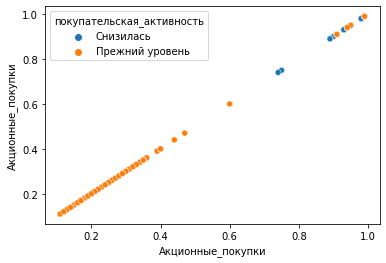

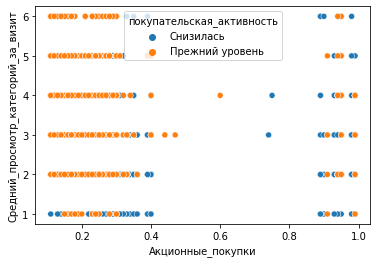

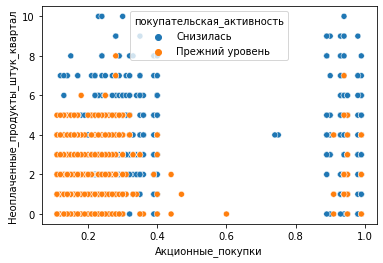

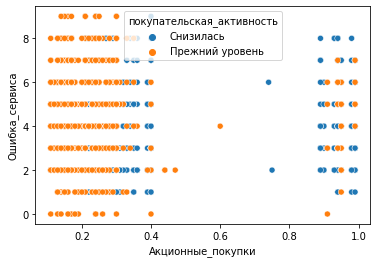

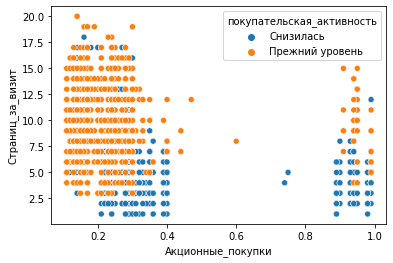

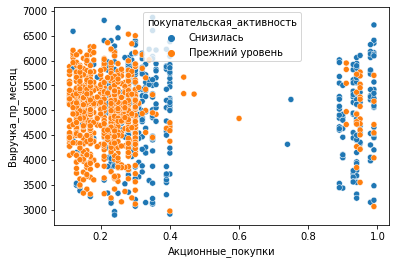

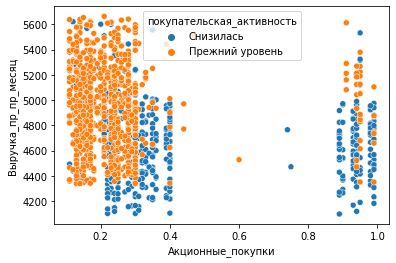

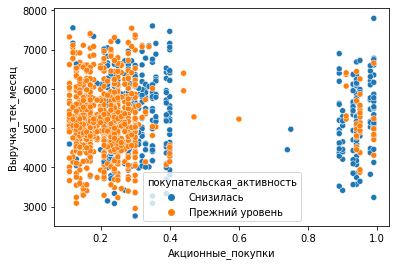

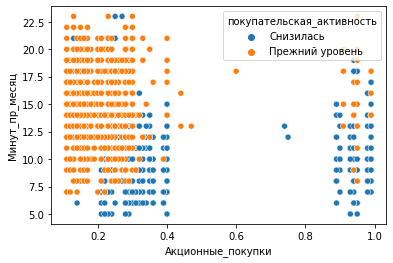

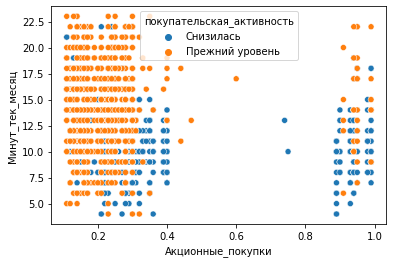

In [40]:
for i in num:
    sns.scatterplot(data=df, x='Акционные_покупки', y=i, hue='покупательская_активность')
    plt.show()

Даже на первый взгляд по диаграмме рассеяния можно увидеть, что наблюдения сгруппированы в два кластера - интервалы, которые я отмечал выше. Количество наблюдений конечно же выше слева. Но чисто визуально получается, что справа преобладает синий цвет - активность снизилась, а справа оранжевый - активность на прежнем уровне. 

Выделю сегмент покупателей с долей акционных покупок больше 0.6

In [41]:
segment = df.query('Акционные_покупки > 0.6')
segment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            166 non-null    object 
 1   Тип сервиса                          166 non-null    object 
 2   Разрешить сообщать                   166 non-null    object 
 3   Маркет_актив_6_мес                   166 non-null    float64
 4   Маркет_актив_тек_мес                 166 non-null    int64  
 5   Длительность                         166 non-null    int64  
 6   Акционные_покупки                    166 non-null    float64
 7   Популярная_категория                 166 non-null    object 
 8   Средний_просмотр_категорий_за_визит  166 non-null    int64  
 9   Неоплаченные_продукты_штук_квартал   166 non-null    int64  
 10  Ошибка_сервиса                       166 non-null    int64  
 11  Страниц_за_визит        

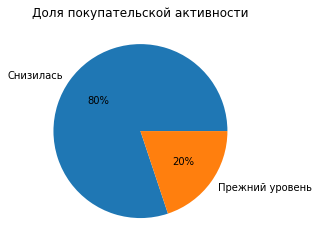

In [42]:
segment['покупательская_активность'].value_counts().plot(kind='pie',autopct='%1.0f%%',legend=None,ylabel='')
plt.title('Доля покупательской активности');

In [43]:
#Для анализа возьму тестовые значения - X, y и вероятность предсказания класса
test_df = X_test.join(y_test)
test_df['y_pred_proba'] = y_test_pred.tolist()
test_df

,Минут_тек_месяц,Минут_пр_месяц,Выручка_тек_месяц,Выручка_пр_пр_месяц,Выручка_пр_месяц,Страниц_за_визит,Средний_просмотр_категорий_за_визит,Акционные_покупки,Маркет_актив_6_мес,target,y_pred_proba
id,,,,,,,,,,,
215950,13,11,5869.4,4415.0,5124.5,8,6,0.25,3.9,0,0.250087
215698,10,12,3520.3,4429.0,3441.0,3,2,0.89,3.5,1,0.974283
216097,6,15,6249.2,4470.0,5353.5,8,4,0.27,5.0,0,0.365823
216381,4,13,5779.2,5526.0,5592.0,18,5,0.23,4.2,0,0.056496
216510,12,20,6411.2,5290.0,5821.0,9,2,0.91,4.9,0,0.374145
...,...,...,...,...,...,...,...,...,...,...,...
216063,22,15,4555.0,4479.0,4074.0,12,2,0.28,5.2,0,0.098074
216013,13,13,5286.8,5518.0,5324.5,12,3,0.47,6.1,0,0.114689
215642,7,7,5455.0,4419.0,4857.0,5,2,0.30,3.8,1,0.958636


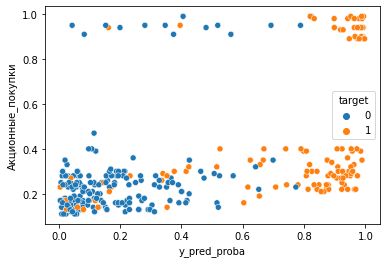

In [44]:
sns.scatterplot(data=test_df, x='y_pred_proba', y='Акционные_покупки', hue='target')
plt.show()

Выше - диаграмма рассеяния с вероятностью и долей акционных покупок, с учетом покупательской активности.

Если с акционными покупками ранее стали понятны границы, то здесь видно, что при значении вероятности >0.6 растет число объектов, отнесенных моделью к категории "снизилась".

Посмотрю какие категории преобладают с разным типом активности.

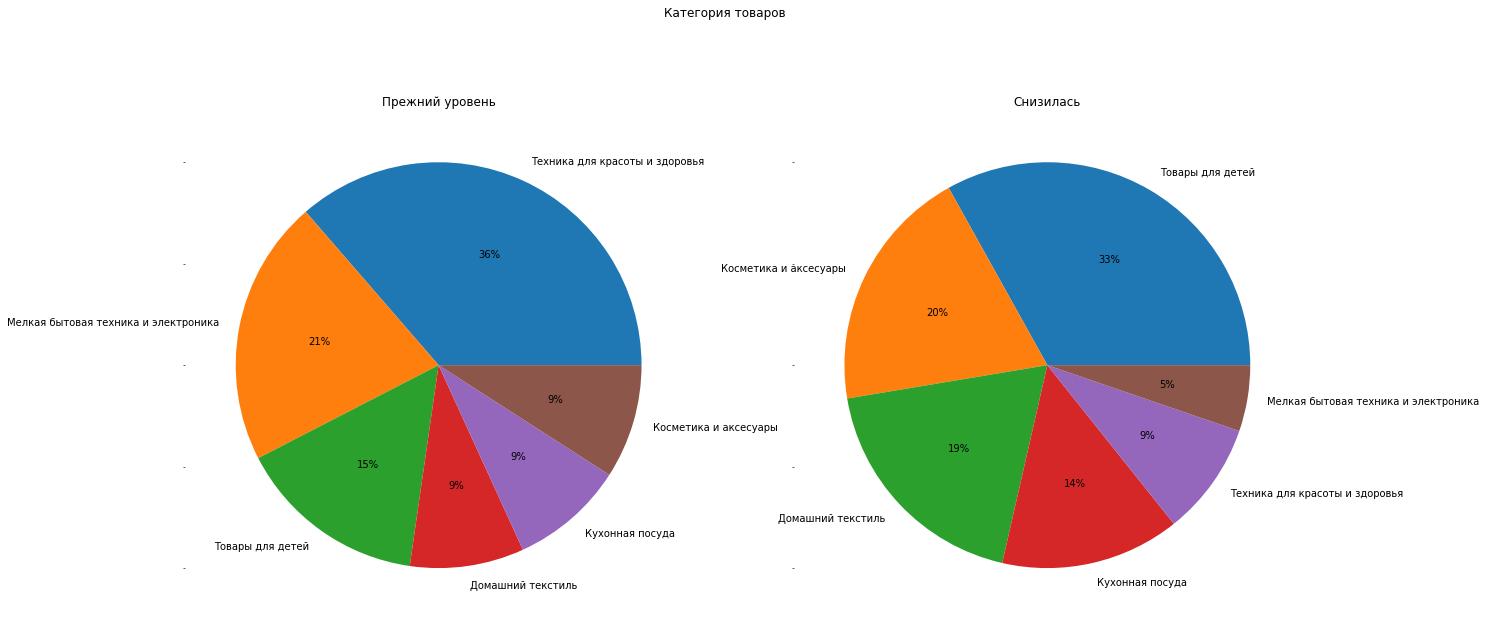

In [45]:
low = segment.query('покупательская_активность == "Снизилась"')
same = segment.query('покупательская_активность == "Прежний уровень"')

fig,(ax0,ax1) = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(20,10));
fig.suptitle('Категория товаров',y=1);
same['Популярная_категория'].value_counts().plot(kind='pie',y='Популярная_категория',ax=ax0,autopct='%1.0f%%',legend=None);
low['Популярная_категория'].value_counts().plot(kind='pie',y='Популярная_категория',ax=ax1,autopct='%1.0f%%',legend=None);
ax0.set(title='Прежний уровень',ylabel='');
ax1.set(title='Снизилась');

**Вывод**

Покупательская активность снижается у тех людей, кто пришел за акционными товарами. Они меньше времени проводят на сайте, у них выше доля неоплаченных товаров.

В качестве рекомендаций, можно выделить следующие пункты:
- предлагать таким клиентам товары из других категорий
- предлагать рассылать информацию текущих скидках и товарах
- предлагать какие-то бонусы и привилегии в рамках типа сервиса
- повышать маркетинговую активность как важный показатель, коррелирующий с целевой переменной

# Шаг 9. Общий вывод

В своей работе я проделал следующие шаги:
- загрузил и предобработал данные
- провел исследовательский анализ данных
- провел корреляционный анализ данных с выявлением значимых признаков
- сделал пайплайн для предобработки данных и поиска лучшей модели прогноза
- проанализировал важность признаков для модели
- произвел сегментацию покупателей и дал рекомендации для одного сегмента

На целевой показатель "Покупательская активность" больше всего влияют показатели:
- выручки
- проведенных минут на сайте
- количество просмотренных страниц за один визит
- количество просмотренных категорий за один визит
- акционные покупки
- маркетинговая активность за 6 месяцев

Судя по рандомизированному поиску параметров, лучшая модель - логистическая регрессия.
При этом точность такой модели на тренировочной выборке составляет 0.9. И на тестовой выборке она не отличается - так же 0.9.

Важный показатель для повышения выручки компании - сегмент клиентов с акционными покупками. Покупательская активность снижается у тех людей, кто пришел за акционными товарами. Они меньше времени проводят на сайте, у них выше доля неоплаченных товаров. В качестве рекомендаций - нужно уделить маркетинговой коммуникации и различным акциям и бонусам этой категории клиентов.
